In [68]:
!pip install torch tqdm pandas numpy

In [69]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df = pd.read_csv('XSS_dataset.csv', index_col=0)
client_losses, client_accuracies = [], []
global_test_accuracies = []

In [71]:
train_df = df[:int(len(df)*0.6)]
test_df = df[int(len(df)*0.4):]

In [72]:
N = 10 # Number of clients
client_data = np.array_split(train_df, N)

In [73]:
def data2char_index(data, max_len):
    alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    mat = []
    for ch in data:
        if ch not in alphabet:
            continue
        mat.append(alphabet.index(ch))
    if len(mat) < max_len:
        mat += [0] * (max_len - len(mat))
    elif len(mat) > max_len:
        mat = mat[:max_len]
    return mat

In [74]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len) -> None:
        self.df = df
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence = self.df['Sentence'].values[index]
        label = self.df['Label'].values[index]
        return torch.tensor(data2char_index(sentence, self.max_len)), torch.tensor(label)


In [75]:
class TextCNN(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size, num_classes, kernel_sizes, num_kernels):
        super(TextCNN, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.convs = torch.nn.ModuleList(
            [torch.nn.Conv2d(1, num_kernels, (K, embedding_size)) for K in kernel_sizes])
        self.dropout = torch.nn.Dropout(0.5)
        self.fc = torch.nn.Linear(len(kernel_sizes) * num_kernels, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, sequence_length, embedding_size]
        x = x.unsqueeze(1)  # [batch_size, 1, sequence_length, embedding_size]
        x = [torch.nn.functional.relu(conv(x)).squeeze(3) for conv in self.convs]  # [batch_size, num_kernels, sequence_length - kernel_size + 1] * len(kernel_sizes)
        x = [torch.nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [batch_size, num_kernels] * len(kernel_sizes)
        x = torch.cat(x, 1) # [batch_size, num_kernels * len(kernel_sizes)]
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc(x)  # (N, C)
        return logit

In [76]:
def train_on_client(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [77]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(vocab_size=70, embedding_size=64, num_classes=2, kernel_sizes=[3, 4, 5], num_kernels=128).to(device)

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()


In [80]:
testDataset = Dataset(test_df, 1000)
testGenerator = torch.utils.data.DataLoader(testDataset, batch_size=128, shuffle=True)

In [81]:
epochs = 10
for epoch in range(epochs):
    epoch_losses, epoch_accuracies = [], []
    for client_idx, client_df in enumerate(client_data):
        train_dataset = Dataset(client_df, 1000)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

        train_loss = train_on_client(model, train_loader, optimizer, loss_fn, device)
        epoch_losses.append(train_loss)
        print(f"Epoch {epoch}, Client {client_idx}, Training loss: {train_loss}")

        client_accuracy = evaluate(model, train_loader, device)
        epoch_accuracies.append(client_accuracy)

    # Aggregate metrics after all clients are trained
    client_losses.append(np.mean(epoch_losses))
    client_accuracies.append(np.mean(epoch_accuracies))

    # Global evaluation after each round of training
    global_accuracy = evaluate(model, testGenerator, device)
    global_test_accuracies.append(global_accuracy)
    print(f"Epoch {epoch} - Average Client Loss: {np.mean(epoch_losses)}, Global Test Accuracy: {global_accuracy}")


Epoch 0, Client 0, Training loss: 0.4744110086134502
Epoch 0, Client 1, Training loss: 0.08383300208619662
Epoch 0, Client 2, Training loss: 0.03702521071370159
Epoch 0, Client 3, Training loss: 0.038318337207393985
Epoch 0, Client 4, Training loss: 0.02576003596186638
Epoch 0, Client 5, Training loss: 0.021392692379387363
Epoch 0, Client 6, Training loss: 0.01585747886981283
Epoch 0, Client 7, Training loss: 0.011630922988323229
Epoch 0, Client 8, Training loss: 0.013797109347901173
Epoch 0, Client 9, Training loss: 0.012498017067887954
Epoch 0 - Average Client Loss: 0.07345238152359213, Global Test Accuracy: 0.9956161714564052
Epoch 1, Client 0, Training loss: 0.016573692239554867
Epoch 1, Client 1, Training loss: 0.00987028590004359
Epoch 1, Client 2, Training loss: 0.009900977269613318
Epoch 1, Client 3, Training loss: 0.018640616509531225
Epoch 1, Client 4, Training loss: 0.013711768385422016
Epoch 1, Client 5, Training loss: 0.011055243401122945
Epoch 1, Client 6, Training loss: 

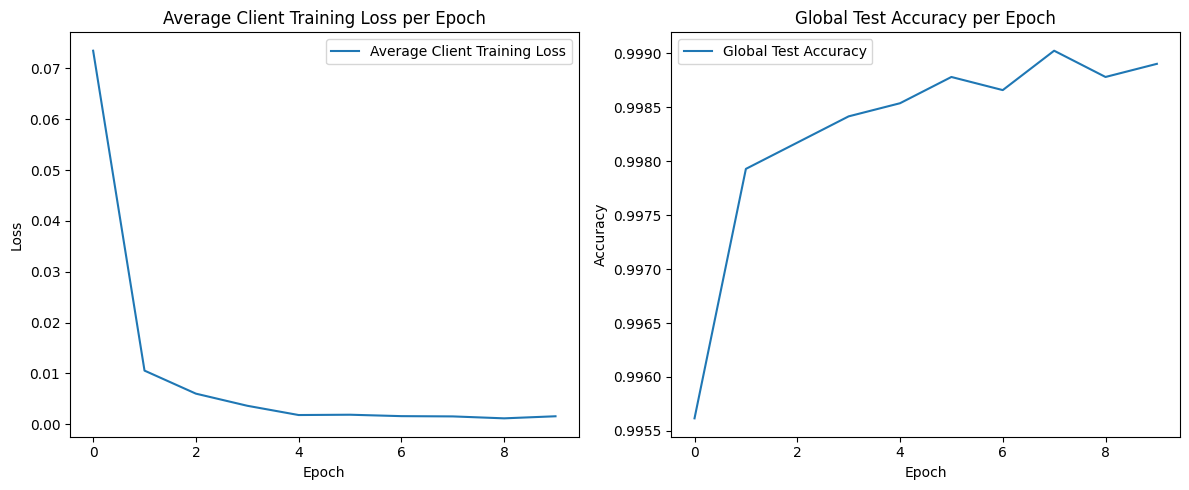

In [82]:
import matplotlib.pyplot as plt

# Plotting Training Loss and Global Test Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(client_losses, label='Average Client Training Loss')
plt.title('Average Client Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(global_test_accuracies, label='Global Test Accuracy')
plt.title('Global Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Evaluation


In [83]:
class Eval():
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0

    def add(self, pred, label):
        if pred == 1 and label == 1:
            self.tp += 1
        elif pred == 1 and label == 0:
            self.fp += 1
        elif pred == 0 and label == 1:
            self.fn += 1
        elif pred == 0 and label == 0:
            self.tn += 1

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.fp + self.fn + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def recall(self):
        return self.tp / (self.tp + self.fn)

In [84]:
eval = Eval()
model.cuda()
model.eval()
for data, label in testGenerator:
    data = data.cuda()
    label = label
    output = model(data).argmax(dim=1).cpu()
    for pred, l in zip(output, label):
        eval.add(pred, l)
print(f"accuracy: {eval.accuracy()}")
print(f"precision: {eval.precision()}")
print(f"recall: {eval.recall()}")

accuracy: 0.9989040428641013
precision: 1.0
recall: 0.9979647218453188


Prediction

In [85]:
def predict(model, input_text, max_len):
    model.eval()  # Set the model to evaluation mode
    processed_input = torch.tensor(data2char_index(input_text, max_len)).unsqueeze(0).to(device)  # Process input text and move to the correct device
    with torch.no_grad():  # Disable gradient calculation
        output = model(processed_input)  # Get model output
        prediction = torch.argmax(output, dim=1).item()  # Get the index of the max log-probability as the prediction
    return prediction


In [86]:
# Example usage
input_text = '<tt onmouseover="alert(1)">test</tt>'  # Replace with your input text
max_len = 1000  # The same max length used during training
prediction = predict(model, input_text, max_len)
print(f"Predicted Label for '{input_text}': {prediction}")


Predicted Label for '<tt onmouseover="alert(1)">test</tt>': 1
